In [599]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [600]:
seed_value = 42
np.random.seed(seed_value)

In [601]:
def read_csv_to_dataframe(file_path):
    dataframe = pd.read_csv(file_path)
    return dataframe

In [602]:
file_path = 'dataset_1.csv' 
df = read_csv_to_dataframe(file_path)
print(df)

     Unnamed: 0  speed  price    hp  mileage     Model
0             0   51.0   35.0  14.0      2.0  Series M
1             1   49.0   30.0  14.0      2.0  Series M
2             2   47.0   32.0  13.0      2.0  Series M
3             3   46.0   31.0  15.0      2.0  Series M
4             4   50.0   36.0  14.0      2.0  Series M
..          ...    ...    ...   ...      ...       ...
145         145   67.0   30.0  52.0     23.0  Series N
146         146   63.0   25.0  50.0     19.0  Series N
147         147   65.0   30.0  52.0     20.0  Series N
148         148   62.0   34.0  54.0     23.0  Series N
149         149   59.0   30.0  51.0     18.0  Series N

[150 rows x 6 columns]


In [611]:
def plot_data_with_line(df, x_column, y_column, color_column, weight_vector, intercept):
    dataframe = df.copy(deep=False)
    plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
    plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
    plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
    x_values = dataframe[x_column].values.tolist()
    line_x = np.linspace(min(x_values), max(x_values), 100)
    line_y = - (weight_vector[0] * line_x + intercept) / weight_vector[1]
    plt.plot(line_x, line_y, color='yellow', label='Line')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"Scatter plot of {y_column} vs {x_column}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

In [604]:
def objective(alpha):
    return 0.5 * np.dot(alpha, np.dot(np.diag(y), np.dot(X, X.T.dot(np.diag(y)).dot(alpha)))) - np.sum(alpha)

def constraint(alpha):
    return np.dot(alpha, y)

def get_svm_weight_vector_and_intercept(X, y, C):
    bounds = [(0, C) for _ in range(len(X))]
    initial_guess = np.random.rand(len(X))
    constraints = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)
    dual_coefficients = result.x
    weight_vector = 0
    for i in range(len(X)):
        weight_vector += (dual_coefficients[i] * y[i] * X[i])
    support_vectors_indices = np.where((dual_coefficients > 1e-5) & (dual_coefficients < C - 1e-5))[0]
    intercept = np.mean(y[support_vectors_indices] - np.dot(X[support_vectors_indices], weight_vector))
    return weight_vector, intercept, len(support_vectors_indices)

/home/ubuntu/py/CS503/envML/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/ubuntu/py/CS503/envML/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/home/ubuntu/py/CS503/envML/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


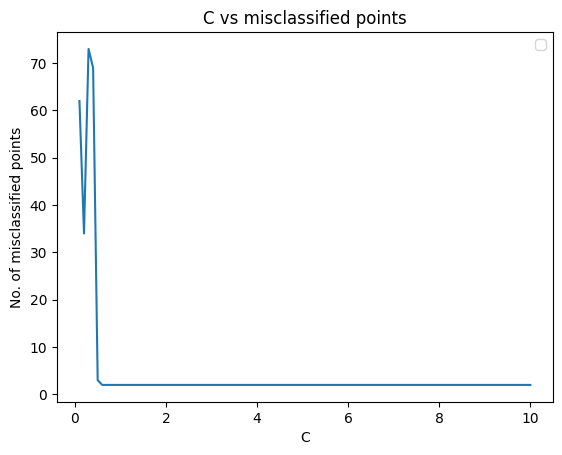

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


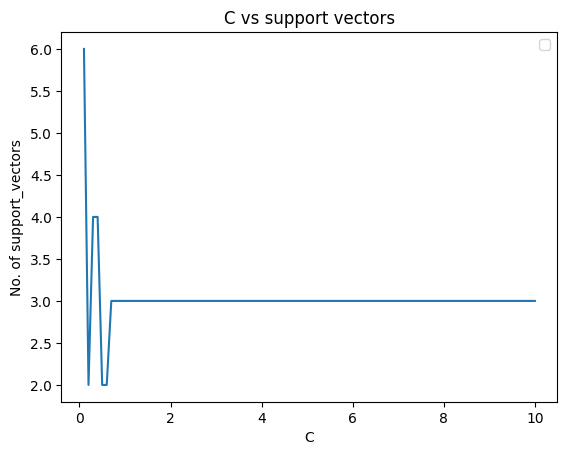

In [605]:
# Checking for each value of C
X = np.array(df[['speed', 'price']].values.tolist())
y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64)

c_list = []
error_list = []
support_vector_list = []
for c in np.arange(0.1, 10.01, 0.1):
    c = round(c, 2)
    c_list.append(c)
    weight_vector_m, intercept_m, support_vectors = get_svm_weight_vector_and_intercept(X, y_m, c)
    weight_vector_n, intercept_n, support_vectors = get_svm_weight_vector_and_intercept(X, y_n, c)
    weight_vector_l, intercept_l, support_vectors = get_svm_weight_vector_and_intercept(X, y_l, c)
    value_1 = 0
    value_2 = 0
    value_3 = 0
    error = 0
    for i in range(len(X)):
        value_1 = (weight_vector_m[0] * X[i][0] + weight_vector_m[1] * X[i][1] + intercept_m) / np.linalg.norm(weight_vector_m)
        value_2 = (weight_vector_n[0] * X[i][0] + weight_vector_n[1] * X[i][1] + intercept_n) / np.linalg.norm(weight_vector_n)
        value_3 = (weight_vector_l[0] * X[i][0] + weight_vector_l[1] * X[i][1] + intercept_l) / np.linalg.norm(weight_vector_l)
        if value_1 >= value_2 and value_1 >= value_3 and i >= 50:
            error += 1
        if value_2 >= value_1 and value_2 >= value_3 and i < 50 and i >=100:
            error += 1
        if value_3 >= value_2 and value_3 >= value_1 and i < 100:
            error += 1
    error_list.append(error)
    support_vector_list.append(support_vectors)
    
plt.plot(c_list, error_list)
plt.xlabel('C')
plt.ylabel('No. of misclassified points')
plt.title('C vs misclassified points')
plt.legend()
plt.show()

plt.plot(c_list, support_vector_list)
plt.xlabel('C')
plt.ylabel('No. of support_vectors')
plt.title('C vs support vectors')
plt.legend()
plt.show()

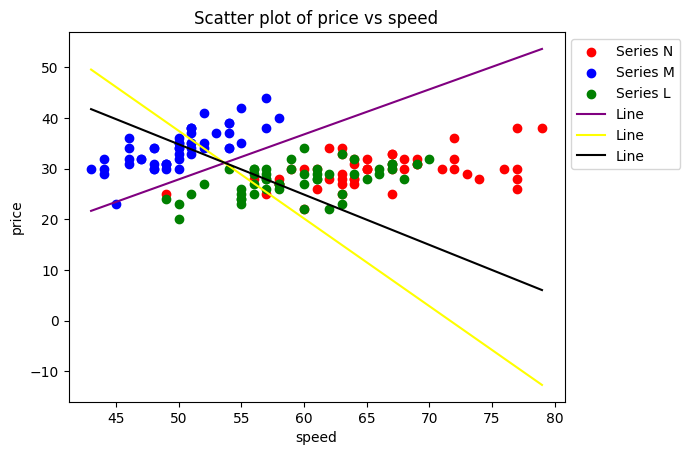

In [629]:
# Finding the equation of hyperplane
X = np.array(df[['speed', 'price']].values.tolist())
C = 0.01




y_m = np.array(df['Model'].replace('Series M', '1').replace('Series N', '-1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_n = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '1').replace('Series L', '-1').values.tolist(), dtype=np.float64)
y_l = np.array(df['Model'].replace('Series M', '-1').replace('Series N', '-1').replace('Series L', '1').values.tolist(), dtype=np.float64) 
weight_vector_m, intercept_m, support_vectors = get_svm_weight_vector_and_intercept(X, y_m, C)
weight_vector_n, intercept_n, support_vectors = get_svm_weight_vector_and_intercept(X, y_n, C)
weight_vector_l, intercept_l, support_vectors = get_svm_weight_vector_and_intercept(X, y_l, C)

x_column = 'speed'
y_column = 'price'
dataframe = df
plt.scatter(dataframe[dataframe['Model'] == 'Series N'][x_column], dataframe[dataframe['Model'] == 'Series N'][y_column], c='red', label='Series N')
plt.scatter(dataframe[dataframe['Model'] == 'Series M'][x_column], dataframe[dataframe['Model'] == 'Series M'][y_column], c='blue', label='Series M')
plt.scatter(dataframe[dataframe['Model'] == 'Series L'][x_column], dataframe[dataframe['Model'] == 'Series L'][y_column], c='green', label='Series L')
x_values = dataframe[x_column].values.tolist()
line_x = np.linspace(min(x_values), max(x_values), 100)
line_y_m = - (weight_vector_m[0] * line_x + intercept_m) / weight_vector_m[1]
line_y_n = - (weight_vector_n[0] * line_x + intercept_n) / weight_vector_n[1]
line_y_l = - (weight_vector_l[0] * line_x + intercept_l) / weight_vector_l[1]
plt.plot(line_x, line_y_m, color='purple', label='Line')
plt.plot(line_x, line_y_n, color='yellow', label='Line')
plt.plot(line_x, line_y_l, color='black', label='Line')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f"Scatter plot of {y_column} vs {x_column}")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

# plot_data_with_line(df, 'speed', 'price', 'Model', weight_vector_m, intercept_m)
# plot_data_with_line(df, 'speed', 'price', 'Model', weight_vector_l, intercept_l)

# plot_data_with_line(df, 'speed', 'price', 'Model', weight_vector_n, intercept_n)

